In [182]:
import pandas as pd
import numpy as np
import pickle as pkl
from torch.utils.data import DataLoader
from transformer_model import Transformer
from sklearn.metrics import f1_score, classification_report

In [ ]:
df_vid = pd.read_csv("../data/master_features.csv", header=0, names=["id", "emb","keystep"])

In [ ]:
df_text = pd.read_csv("../youcook2/reviewed_0812.csv")

In [3]:
def convert_to_arr(input_str, dim):
    if dim == 1:
        input_str = input_str[1:-1]
    elif dim == 2:
        input_str = input_str.replace(" ", "")  # Remove spaces
        input_str = input_str.replace("][", "],[")  # Add commas between sub-arrays
    else:
        raise NotImplementedError

    # Evaluating the string to create a nested list
    nested_list = eval(input_str)

    # Converting the nested list to a numpy array
    np_array = np.array(nested_list)
    return np_array

In [4]:
def get_id(url):
    url_parts = url.split("?")

    # Extracting the query parameters part of the URL
    query_params = url_parts[1] if len(url_parts) > 1 else ""

    # Splitting the query parameters by "&" to separate individual key-value pairs
    query_params = query_params.split("&")

    # Extracting the video ID from the query parameters
    video_id = ""
    for param in query_params:
        if param.startswith("v="):
            video_id = param[2:]
        break
    return video_id

In [ ]:
df_text["VideoID"] = df_text["VideoUrl"].apply(get_id)

In [ ]:
# Sanity check to test if each transcript sentence has a frame assosciated to it.

# valid = 0
# for i in range(df_vid.shape[0]):
#     vid_name, vid_arr, vid_key = df_vid.iloc[i][0], convert_to_arr(df_vid.iloc[i][1],dim=2), convert_to_arr(df_vid.iloc[i][2],dim=1)
#     print(vid_arr.shape[0], len(df_text[df_text["VideoID"].str.contains(vid_name)]))
#     if vid_arr.shape[0] == len(df_text[df_text["VideoID"].str.contains(vid_name)]):
#         valid +=1
#     break
# print("Valid video: {}, Total :{}".format(valid, df_vid.shape[0]))

In [ ]:
data_pkl = {}
for i in range(df_vid.shape[0]):
    vid_name, vid_arr, vid_key = df_vid.iloc[i][0], convert_to_arr(df_vid.iloc[i][1],dim=2), convert_to_arr(df_vid.iloc[i][2],dim=1)
    matches = df_text["VideoID"].str.contains(vid_name)
    asset vid_arr.shape[0] == len(df_text.loc[matches]["Sentence"].values)
    data_pkl[vid_name] = {}
    data_pkl[vid_name]["Sentence"] = df_text.loc[matches]["Sentence"].values
    data_pkl[vid_name]["IsUsefulSentence"] = df_text.loc[matches]["IsUsefulSentence"].values
    data_pkl[vid_name]["Key steps"] = df_text.loc[matches]["Key steps"].values
    data_pkl[vid_name]["Verb"] = df_text.loc[matches]["Verb"].values
    data_pkl[vid_name]["Object"] = df_text.loc[matches]["Object(directly related with Verb)"].values
    data_pkl[vid_name]["img_feat"] = vid_arr

In [ ]:
with open("../data/img_text_comb_updated.pkl", "wb") as f:
    pkl.dump(data_pkl, f)

In [5]:
with open("../data/img_text_comb_updated.pkl", "rb") as f:
    data_pkl = pkl.load(f)

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [6]:
from tqdm import tqdm as tqdm

In [ ]:
for key in tqdm(data_pkl.keys()):
    sentences = data_pkl[key]["Sentence"]
    embeddings = model.encode(sentences)
    data_pkl[key]["text_emb(all-MiniLM-L6-v2)"] = embeddings

In [ ]:
from sklearn.metrics import pairwise_distances

In [ ]:
cosine_dist = pairwise_distances(embeddings, metric="cosine")

In [ ]:
for i in range(10):
    min_dist = np.argsort(cosine_dist[i])[1]
    print(f"{sentences[i]} |||||| {sentences[min_dist]}")
    print("-------")

In [7]:
split_df = pd.read_csv("../data/train_val_split.csv")

In [8]:
train_url = split_df[split_df.Split == "train"]["VideoUrl"]
val_url = split_df[split_df.Split == "val"]["VideoUrl"]

In [9]:
train_id = list(map(get_id, train_url))
val_id = list(map(get_id, val_url))

In [10]:
train_data = {}
test_data = {}

In [11]:
for v_id in train_id:
    if v_id not in data_pkl.keys():
        print(v_id)
        continue
    else:
        train_data[v_id] = data_pkl[v_id]

5nh2CP22dgY
oJZUxU9szWA
so-RuJQY1d0
psXv6tX1GnA
Vy5ypC9_cOs
lBguj96fa5w


In [12]:
for v_id in val_id:
    if v_id not in data_pkl.keys():
        print(v_id)
        continue
    else:
        test_data[v_id] = data_pkl[v_id]

okvTq8gtr8c
_gG0As2y92g
btikV_DUoCM
-goI2-eJO1w


In [212]:
import torch

class YouCookData(torch.utils.data.Dataset):
    def __init__(self, data, seq_len = 136):
        # Merge resnet feat + text --> S, D --> Pad till 136 --> Return inp + mask
        self.input = []
        self.mask = []
        self.labels = []
        i=0
        for vid_name in tqdm(data.keys()):
            txt_emb = data[vid_name]["text_emb(all-MiniLM-L6-v2)"]
            img_emb = data[vid_name]["img_feat"]
            label = np.array(data[vid_name]["IsUsefulSentence"])
            if txt_emb.shape[0] !=  img_emb.shape[0]:
                print(vid_name)
                i += 1
                continue
            concat_emb = np.concatenate((txt_emb, img_emb), axis=1)
#             concat_emb = txt_emb
            len_story = concat_emb.shape[0]
            if len_story < seq_len:
                padding = np.zeros((seq_len-len_story, concat_emb.shape[1]))
                concat_emb = np.concatenate((concat_emb, padding), axis=0)
                label = np.concatenate((label, -1*np.ones(seq_len-len_story)))
                
            mask = np.zeros(seq_len)
            mask[:len_story] = 1
            self.input.append(concat_emb)
            self.mask.append(mask)
            self.labels.append(label)

    def __getitem__(self, idx):
        return torch.from_numpy(self.input[idx]), torch.from_numpy(self.mask[idx]), torch.from_numpy(self.labels[idx])

    def __len__(self):
        return len(self.labels)

In [213]:
len(train_data.keys()), len(test_data.keys())

(247, 95)

In [214]:
train_dataset = YouCookData(train_data)
test_dataset = YouCookData(test_data)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 1549.81it/s]


In [215]:
# invalid_keys = ["5nh2CP22dgY", "oJZUxU9szWA", "so-RuJQY1d0", "psXv6tX1GnA", "lBguj96fa5w","okvTq8gtr8c","_gG0As2y92g", "btikV_DUoCM", "-goI2-eJO1w"]
# for key in invalid_keys:
#     data_pkl.pop(key)

In [216]:
batchsize=64
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

In [217]:
def train_one_epoch(model: torch.nn.Module, training_data_loader: DataLoader, optimizer: torch.optim.Optimizer, logging_frequency: int, testing_data_loader: DataLoader, logger: dict):
    model.train()
    optimizer.zero_grad()
    epoch_loss = 0
    logging_loss = 0
    start_time = time.time()
    mini_start_time = time.time()
    for step, batch in enumerate(training_data_loader):
        inp, mask, label = batch
        inp = inp.float().cuda()
        mask = mask.long().cuda()
        label = label.long().cuda()
        
        outputs = model(inp, mask, label)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        logging_loss += loss.item()
#         print(f"Training loss @ step {step+1}: {loss.item()}")

#         if (step + 1) % logging_frequency == 0:
#             freq_time = time.time()-mini_start_time
#             logger['train_time'].append(freq_time+logger['train_time'][-1])

#             print(f"Training loss @ step {step+1}: {logging_loss/logging_frequency}")
#             logger['eval_accs'].append(eval_acc)
#             logger['eval_losses'].append(eval_loss)
#             logger['eval_time'].append(eval_time+logger['eval_time'][-1])
#             # logger['mem_alloc'].append(torch.cuda.memory_allocated()/(1024*1024))

    print("Running Evaluation Step")
    eval_f1, eval_loss = evaluate(model, testing_data_loader)
    
    print(f"Evaluation Loss, F1: {eval_loss}, {eval_f1}")
    return epoch_loss / len(training_data_loader), eval_loss, eval_f1


def evaluate(model: torch.nn.Module, test_data_loader: DataLoader):
    model.eval()
    eval_loss = 0
    correct_predictions = {i: 0 for i in range(2)}
    total_predictions = {i: 0 for i in range(2)}
    start_time = time.time()
    targets = []
    prediction_list= []
    with torch.no_grad():
        for step, batch in enumerate(test_data_loader):
            inp, mask, label = batch
            inp = inp.float().cuda()
            mask = mask.long().cuda()
            label = label.long().cuda()
            outputs = model(inp, mask, label)
            loss = outputs[0]
            eval_loss += loss.item()
            predictions = np.argmax(outputs[1].detach().cpu().numpy(), axis=2)
            
            target = label.cpu().numpy()
            target_mask = target != -1
            
            target = target[target_mask]
            predictions = predictions[target_mask]
            
            targets.extend(list(target))
            prediction_list.extend(list(predictions))
    
    targets = np.array(targets)
    prediction_list = np.array(prediction_list)

    print(classification_report(targets, prediction_list))
    
    f1 = f1_score(targets, prediction_list, labels=[1])
    model.train()
    return f1,  eval_loss / len(test_data_loader)

In [218]:
def get_logger(model):
    logger = dict()
    logger['train_losses'] = []
    logger['eval_f1'] = []
    logger['eval_losses'] = []
#     logger['parameters'] = sum([p.numel() for p in model.back_bone.parameters() if p.requires_grad])
    return logger

In [219]:
def save_logs(dictionary, log_dir, exp_id):
    log_dir = os.path.join(log_dir, exp_id)
    os.makedirs(log_dir, exist_ok=True)
    # Log arguments
    with open(os.path.join(log_dir, "args.json"), "w") as f:
        json.dump(dictionary, f, indent=2)


In [220]:
import time,os,json

In [221]:
learning_rate = 1e-4
num_epochs = 50
logging_frequency = 10
model = Transformer(embed_dim=896, num_heads=4, num_layers=4, block='postnorm', dropout=0.3)
model.cuda()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, eps=1e-8)    
logger = get_logger(model)
best_f1=0
best_epoch = 0
for i in range(num_epochs):
    train_loss, val_loss, val_f1 = train_one_epoch(model, train_loader, optimizer, logging_frequency, test_loader, logger)
    print("Train loss: {}".format(train_loss))
    if val_f1 > best_f1:
        best_f1 = val_f1
        best_epoch = i
        torch.save(model.state_dict(),"../models/attention_keyclip/best_model.pkl")
        
    logger['train_losses'].append(train_loss)
    logger['eval_losses'].append(val_loss)
    logger['eval_f1'].append(val_f1)
    save_logs(logger, "../logs/attention_keyclip", "1")
    

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.00      0.00      0.00      1000

    accuracy                           0.77      4346
   macro avg       0.38      0.50      0.43      4346
weighted avg       0.59      0.77      0.67      4346

Evaluation Loss, F1: 0.842398077249527, 0.0
Train loss: 0.7321026474237442


/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.82      0.57      0.67      3346
           1       0.29      0.57      0.38      1000

    accuracy                           0.57      4346
   macro avg       0.55      0.57      0.53      4346
weighted avg       0.69      0.57      0.61      4346

Evaluation Loss, F1: 0.7147001922130585, 0.38085742771684944
Train loss: 0.6046101599931717
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3346
           1       0.37      0.14      0.20      1000

    accuracy                           0.75      4346
   macro avg       0.57      0.53      0.53      4346
weighted avg       0.69      0.75      0.70      4346

Evaluation Loss, F1: 0.5332165658473969, 0.20058139534883723
Train loss: 0.7093828767538071
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00  

/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      1.00      0.87      3346
           1       0.00      0.00      0.00      1000

    accuracy                           0.77      4346
   macro avg       0.38      0.50      0.43      4346
weighted avg       0.59      0.77      0.67      4346

Evaluation Loss, F1: 0.6265842318534851, 0.0
Train loss: 0.59869584441185


/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/a/aasheesh.singh/torch_env/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      3346
           1       0.35      0.14      0.20      1000

    accuracy                           0.74      4346
   macro avg       0.57      0.53      0.52      4346
weighted avg       0.68      0.74      0.70      4346

Evaluation Loss, F1: 0.5390229225158691, 0.2027123483226267
Train loss: 0.5487867146730423
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.78      0.93      0.85      3346
           1       0.37      0.14      0.21      1000

    accuracy                           0.75      4346
   macro avg       0.58      0.53      0.53      4346
weighted avg       0.69      0.75      0.70      4346

Evaluation Loss, F1: 0.532854437828064, 0.20575539568345322
Train loss: 0.5833135694265366
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.77      0.99    

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.78      0.95      0.86      3346
           1       0.44      0.12      0.19      1000

    accuracy                           0.76      4346
   macro avg       0.61      0.54      0.53      4346
weighted avg       0.70      0.76      0.71      4346

Evaluation Loss, F1: 0.5289374440908432, 0.19299610894941635
Train loss: 0.49948087334632874
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      3346
           1       0.41      0.17      0.24      1000

    accuracy                           0.75      4346
   macro avg       0.60      0.55      0.54      4346
weighted avg       0.70      0.75      0.71      4346

Evaluation Loss, F1: 0.540719598531723, 0.23654390934844197
Train loss: 0.4936366677284241
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.79      0.93  

Running Evaluation Step
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      3346
           1       0.40      0.17      0.24      1000

    accuracy                           0.75      4346
   macro avg       0.59      0.55      0.54      4346
weighted avg       0.70      0.75      0.71      4346

Evaluation Loss, F1: 0.5738479197025299, 0.23587570621468926
Train loss: 0.46282779425382614
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.79      0.90      0.84      3346
           1       0.38      0.21      0.27      1000

    accuracy                           0.74      4346
   macro avg       0.59      0.55      0.56      4346
weighted avg       0.70      0.74      0.71      4346

Evaluation Loss, F1: 0.5873771011829376, 0.2677063027940221
Train loss: 0.4649158790707588
Running Evaluation Step
              precision    recall  f1-score   support

           0       0.80      0.89  

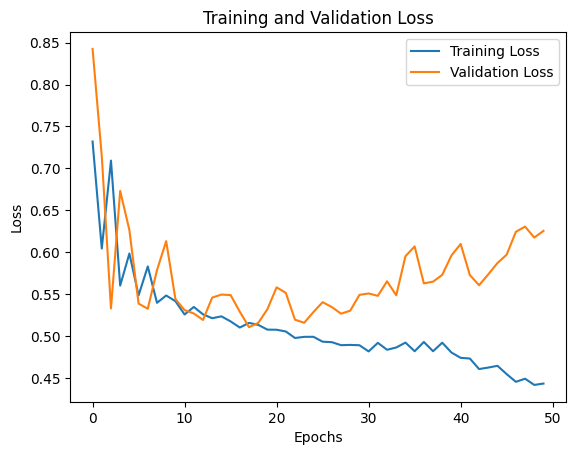

In [222]:
epochs = range(num_epochs)
 
# Plot and label the training and validation loss values
plt.plot(epochs, logger["train_losses"], label='Training Loss')
plt.plot(epochs, logger['eval_losses'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
# plt.xticks(arange(0, 21, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

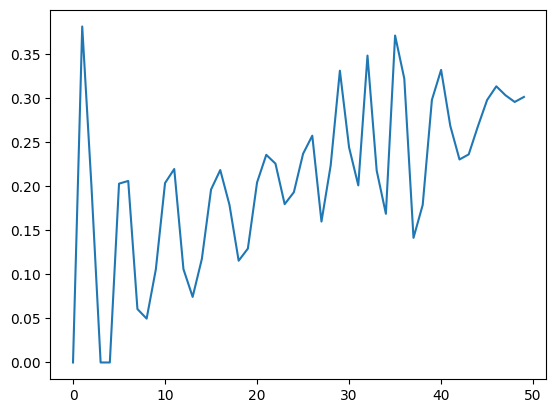

In [223]:
plt.figure()
plt.plot(epochs, logger["eval_f1"], label='Eval f1')
plt.show()

In [225]:
print(best_f1)

0.38085742771684944


In [211]:
model.load_state_dict(torch.load("../models/attention_keyclip/best_model.pkl"))
a,b = evaluate(model, test_loader)
del model

              precision    recall  f1-score   support

           0       0.79      0.93      0.85      3346
           1       0.40      0.16      0.23      1000

    accuracy                           0.75      4346
   macro avg       0.59      0.54      0.54      4346
weighted avg       0.70      0.75      0.71      4346

